In [1]:
!nvidia-smi

Mon Jun  6 20:43:23 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:3B:00.0 Off |                  N/A |
| 23%   26C    P8    16W / 250W |  10916MiB / 11178MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:5E:00.0 Off |                  N/A |
| 23%   

In [2]:
from jarvis.utils.general import gpus

gpus.autoselect()

[ 2022-06-06 20:43:24 ] WARNING 1 GPU device(s) requested but only 0 available 


In [3]:
import numpy as np
from jarvis.train import datasets
from jarvis.utils.display import imshow
from tensorflow.keras import Input
from jarvis.train.client import Client

In [4]:
# --- prepare generators
client = Client('/data/raw/miccai_rsna/data/ymls/client-3d.yml')
gen_train, gen_valid = client.create_generators()

[[[[1]]]]


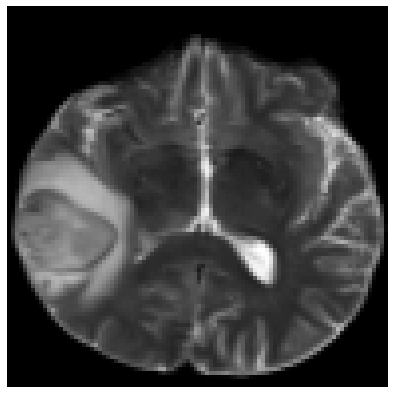

In [5]:
# --- Show a sample training set
xs, ys = next(gen_train)
imshow(xs['t2w'][0][24], radius=1)
print(ys['lbl'][0])

In [6]:
xs.keys()

dict_keys(['t2w', 't1w', 't1wce', 'fla', 'lbl'])

In [7]:
# --- Print keys 
for key, arr in xs.items():
    print('xs key: {} | shape = {}'.format(key.ljust(8), arr.shape))

xs key: t2w      | shape = (4, 48, 96, 96, 1)
xs key: t1w      | shape = (4, 48, 96, 96, 1)
xs key: t1wce    | shape = (4, 48, 96, 96, 1)
xs key: fla      | shape = (4, 48, 96, 96, 1)
xs key: lbl      | shape = (4, 1, 1, 1, 1)


In [8]:
# --- Create model inputs
inputs = client.get_inputs(Input)